In [1]:
import sys
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import cm

# Custom package
sys.path.append('/home/rrp000/sea_ice/code/')
from icepack import get_dataset
from icepack.analysis import *
from icepack.splot import *

# Some useful lists and dicts
monthletters = ['J','F','M','A','M','J','J','A','S','O','N','D']
monthstr = ['01','02','03','04','05','06','07','08','09','10','11','12']
monthdict = {1:r'$\mathbf{January}$',
             2:r'$\mathbf{February}$',
             3:r'$\mathbf{March}$',
             4:r'$\mathbf{April}$',
             5:r'$\mathbf{May}$',
             6:r'$\mathbf{June}$',
             7:r'$\mathbf{July}$',
             8:r'$\mathbf{August}$',
             9:r'$\mathbf{September}$',
             10:r'$\mathbf{October}$',
             11:r'$\mathbf{November}$',
             12:r'$\mathbf{December}$'}

method = 'mean'
daterange = (1990,2014)
daterange_clim = (1990,2014)
mask = xr.open_dataset("~/sea_ice/data/masks/land_all.nc")

# Open Data

In [2]:
# open data
sic = get_dataset('Had2CIS')

# calculate SIE and anomalies
sie_Had2CIS = get_iceextent(sic, mask, lat_bounds=(-90,0), ensemble=None)
sie_anom_Had2CIS = get_anomalies(sie_Had2CIS,'SIE',ref_period=daterange)
sie_clim_Had2CIS = get_climatology(sie_Had2CIS,var='SIE',ref_period=daterange_clim)

In [8]:
# open data and format time
sic_CanESM5_init = get_dataset('GEM5.2-NEMO_i')
sic_CanESM5_init = [format_time_coord(data,f'1990-{monthstr[i]}',f'202{int(np.heaviside(i,0))}-{monthstr[i-1]}',freq='M') for i,data in enumerate(sic_CanESM5_init)]

# calculate SIE (ensemble mean) and SIE anomalies
sie_anom_CanESM5_init_lt_ens = []
for e in range(10):
    print(f"Calculating SIE for {e}")
    sie_CanESM5_init = []
    for i,sic in enumerate(sic_CanESM5_init):
        sie_CanESM5_init.append(get_iceextent(sic, mask, lat_bounds=(-90,0), ensemble=e, multiply_input_by=1))
    sie_anom_CanESM5_init = [get_anomalies(sie,'SIE',ref_period=daterange) for sie in sie_CanESM5_init]

    # add a lead time coordinate to the SIE data set
    print("Adding a lead time coordinate")
    for i in range(len(sie_CanESM5_init)):
        im = i + 1
        sie_CanESM5_init[i]['lead'] = (sie_CanESM5_init[i]['time.month'] - im)%12
        sie_anom_CanESM5_init[i]['lead'] = (sie_anom_CanESM5_init[i]['time.month'] - im)%12

    # re-sort by leadtime
    # sie_CanESM5_init_lt = [xr.merge([sie_CanESM5_init[im-1].where(sie_CanESM5_init[im-1]['lead']==lead,drop=True) for im in np.arange(1,13)]) for lead in range(12)]
    sie_anom_CanESM5_init_lt = [xr.merge([sie_anom_CanESM5_init[im-1].where(sie_anom_CanESM5_init[im-1]['lead']==lead,drop=True) for im in np.arange(1,13)]) for lead in range(12)]
    sie_anom_CanESM5_init_lt_ens.append(sie_anom_CanESM5_init_lt)


Calculating SIE for 0
Adding a lead time coordinate
Calculating SIE for 1
Adding a lead time coordinate
Calculating SIE for 2
Adding a lead time coordinate
Calculating SIE for 3
Adding a lead time coordinate
Calculating SIE for 4
Adding a lead time coordinate
Calculating SIE for 5
Adding a lead time coordinate
Calculating SIE for 6
Adding a lead time coordinate
Calculating SIE for 7
Adding a lead time coordinate
Calculating SIE for 8
Adding a lead time coordinate
Calculating SIE for 9
Adding a lead time coordinate


# Plot

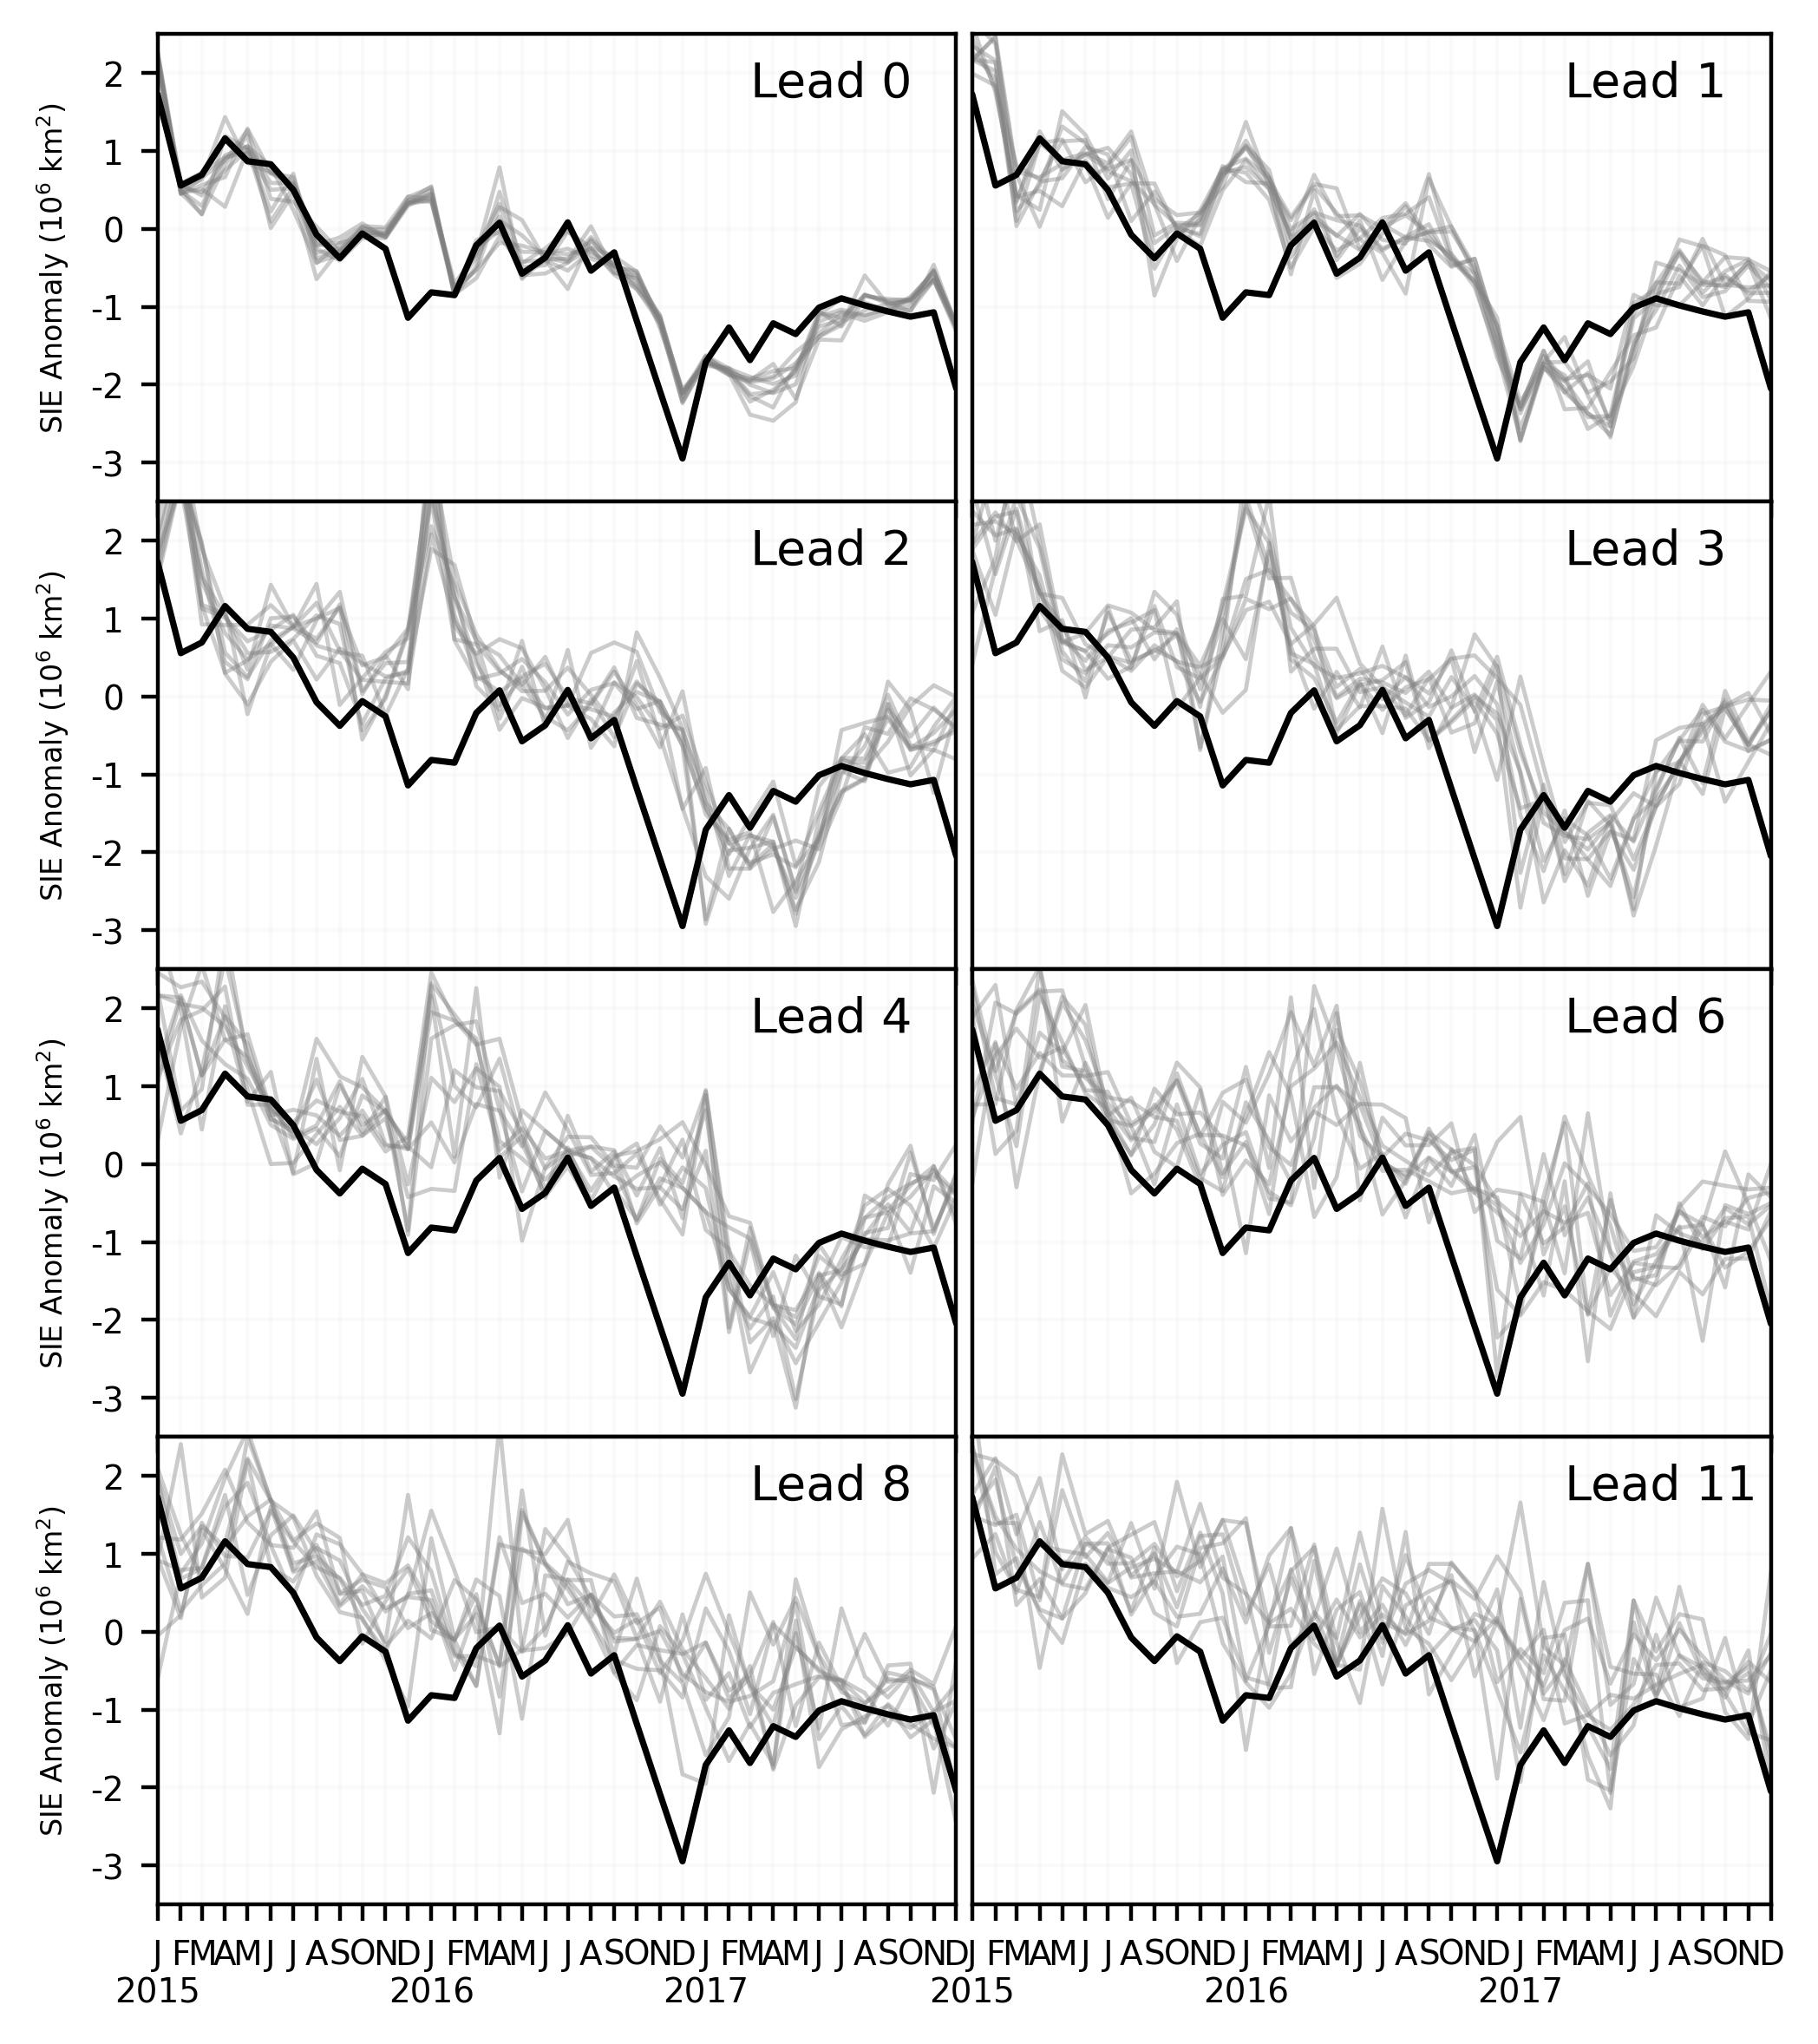

In [9]:
ncols=2
nrows=4
fig, ax = plt.subplots(ncols=ncols,nrows=nrows,facecolor='white',figsize=(6,7),dpi=400,sharey=True,sharex=True)
fig.subplots_adjust(wspace=0.04,hspace=0)
y0,y1 = [2015,2017]
colors = cm.RdBu(np.linspace(0,1,10))
# plt.suptitle("CanESM5.1 Ensemble Spread",y=0.92)
for i in np.arange(nrows): 
    for j in np.arange(ncols): 

        if i <= 1:
            lead = ncols*i + j
        elif (i==nrows-1) and (j==ncols-1):
            lead = 11
        else:
            lead = 2*(ncols*i + j) - 4

        for ens in range(10):
            data = sie_anom_CanESM5_init_lt_ens[ens][lead]
            data = data.where((data['time.year']>=y0)&(data['time.year']<=y1),drop=True)
            data['SIE'].plot.line(ax=ax[i][j],linewidth=.85,color='grey',alpha=0.4)
        sie_anom_Had2CIS['SIE'].plot.line(ax=ax[i][j],linewidth=1.3,color='black')

        ax[i][j].text(np.datetime64(f"{y1}-03"),1.7,f"Lead {lead}")
        xlabels = monthletters*(y1-y0+1)
        for k,yr in enumerate(np.arange(y0,y1+1,1)):
            xlabels[12*k] += f'\n{yr}'
        ax[i][j].set_xlim(np.datetime64(f"{y0}-01"),np.datetime64(f"{y1}-12"))
        ax[i][j].set_xticks(np.arange(np.datetime64(f"{y0}-01"),np.datetime64(f"{y1+1}-01"),np.timedelta64(1,"M")))
        ax[i][j].set_xticklabels(xlabels,size=7)
        ax[i][j].set_xlabel(None)
        ax[i][0].set_ylabel(r"SIE Anomaly ($10^6\ \mathrm{km}^2$)",size=6)
        ax[i][1].set_ylabel(None)
        ax[i][j].set_yticks(np.arange(-3,3,1))
        ax[i][j].set_yticklabels(np.arange(-3,3,1),size=7)
        ax[i][1].tick_params(left=False)
        ax[i][j].set_ylim(-3.5,2.5)
        ax[i][j].grid(alpha=0.05)
        #ax[i][j].legend(list(np.arange(10))+["Obs"],fontsize=5,ncols=3,frameon=False)
plt.subplots_adjust(wspace=.02)
plt.show()